In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plotly.express as px
import warnings
import plotly.express as px
# Ignore warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

In [6]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/online_retail.csv", encoding='unicode_escape')

In [7]:
# Data overview
print(df.head(3))
print("Shape:", df.shape)
print(df.info())
print(df.describe())

  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   C

In [8]:
# Handle missing values
df.dropna(subset=["CustomerID"], inplace=True)
df.drop_duplicates(inplace=True)

In [9]:
# Keep only positive quantity values
df = df[df['Quantity'] > 0]

In [10]:
# Convert InvoiceDate to datetime
df["Date"] = pd.to_datetime(df["InvoiceDate"])

In [11]:
# Define reference date for Recency Calculation
reference_date = max(df["Date"]) + pd.DateOffset(days=1)

In [12]:
# Calculate RFM metrics
recency = (reference_date - df.groupby('CustomerID')["Date"].max()).dt.days
frequency = df.groupby('CustomerID')['Date'].count()
df["Total_Price"] = df["Quantity"] * df["UnitPrice"]
monetary = df.groupby('CustomerID')["Total_Price"].sum()

In [13]:
# Create RFM DataFrame
rfm = pd.DataFrame({
    'CustomerID': recency.index,
    'Recency': recency.values,
    'Frequency': frequency.values,
    'Monetary': monetary.values
})

In [14]:
# Assign RFM scores using quantiles
rfm['Recency_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['Frequency_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

In [15]:
# Log transformation for normalization
rfm["log_Recency"] = np.log1p(rfm["Recency"])
rfm["log_Frequency"] = np.log1p(rfm["Frequency"])
rfm["log_Monetary"] = np.log1p(rfm["Monetary"])

In [16]:
# Find optimal K using Elbow Method
inertia = []
X = rfm[["Recency_Score", "Frequency_Score", "Monetary_Score"]]
for i in range(2, 13):
    kmeans = KMeans(n_clusters=i, random_state=14, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [17]:
# Apply K-Means Clustering
optimal_clusters = 4  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=14, n_init=10)
kmeans.fit(X)
rfm["Clusters"] = kmeans.predict(X)

In [18]:
# Cluster insights
print("Cluster Distribution:")
print(rfm["Clusters"].value_counts())

Cluster Distribution:
Clusters
1    1310
3    1141
2     987
0     901
Name: count, dtype: int64


In [19]:
# Cluster-wise mean RFM scores
avg_clusters = rfm.groupby("Clusters")[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].mean()
print(avg_clusters)

          Recency_Score  Frequency_Score  Monetary_Score
Clusters                                                
0              2.189789         3.537181        3.584906
1              4.366412         4.500000        4.478626
2              3.862209         2.052685        2.007092
3              1.384750         1.582822        1.699387


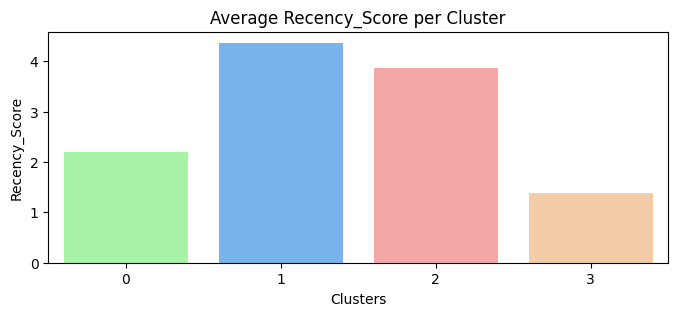

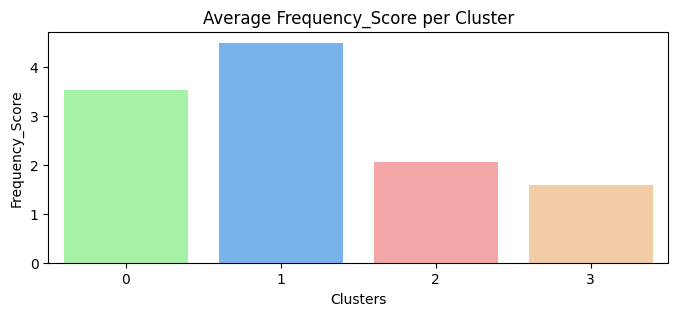

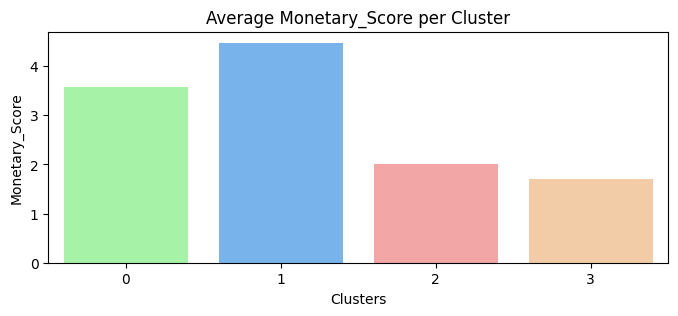

In [20]:
# Visualize clusters
colors = ['#99ff99', '#66b3ff', '#ff9999', '#ffcc99']
lst = ["Recency_Score", "Frequency_Score", "Monetary_Score"]
for i in range(3):
    plt.figure(figsize=(8, 3))
    sns.barplot(data=avg_clusters, x=avg_clusters.index, y=lst[i], palette=colors)
    plt.xlabel("Clusters")
    plt.title(f"Average {lst[i]} per Cluster")
    plt.show()

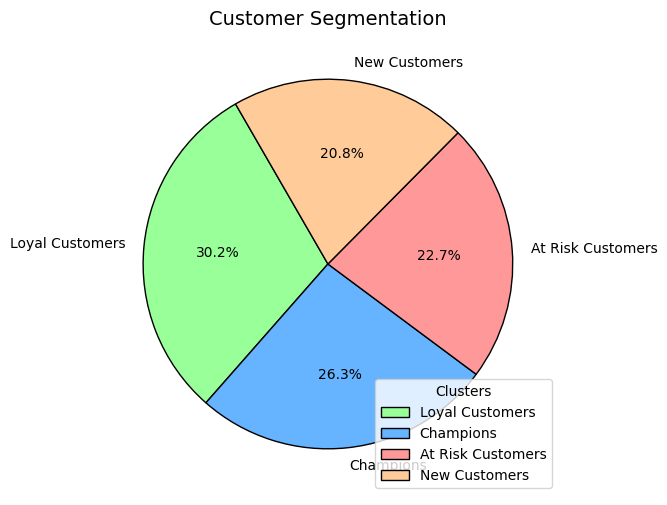

In [21]:
# Pie chart for segmentation
labels = ['Loyal Customers', 'Champions', 'At Risk Customers', 'New Customers']
sizes = (rfm["Clusters"].value_counts() / rfm.shape[0]) * 100
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=120, wedgeprops={'edgecolor': 'black'})
plt.title('Customer Segmentation', fontsize=14)
plt.legend(title='Clusters', loc='best')
plt.show()

In [22]:
# Save results
rfm.to_csv("Customer_Segmentation.csv", index=False)
joblib.dump(kmeans, "customer_segmentation_model.pkl")

['customer_segmentation_model.pkl']

In [23]:
# Predict new customer segment
data = pd.DataFrame([[1, 2, 3]], columns=["Recency_Score", "Frequency_Score", "Monetary_Score"])
print("Predicted Cluster:", kmeans.predict(data)[0])

Predicted Cluster: 3


In [24]:
# 3D Visualization of clusters
fig = px.scatter_3d(rfm, x='log_Recency', y='log_Frequency', z='log_Monetary', color=rfm['Clusters'].astype(str))
fig.show()

In [25]:
# Read the saved CSV to verify
print(pd.read_csv("Customer_Segmentation.csv").head(2))

   CustomerID  Recency  Frequency  Monetary  Recency_Score  Frequency_Score  \
0     12346.0      326          1   77183.6              1                1   
1     12347.0        2        182    4310.0              5                5   

   Monetary_Score  log_Recency  log_Frequency  log_Monetary  Clusters  
0               5     5.789960       0.693147     11.253955         0  
1               5     1.098612       5.209486      8.368925         1  
